## Link streets

#### Link unique IDs of streets to buildings and tessellation cells based on the nearest neighour join.

In [8]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import momepy
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
import geopy
import mapclassify
import folium

output_notebook()

Loading BokehJS ...

In [9]:
place = "Znojmo, Czechia"
local_crs = 5514

In [10]:
buildings = osmnx.features_from_place(place, tags={"building": True})
buildings.head()

geometry building bunker_type historic  \
element id                                                                    
node    3372076291  POINT (16.05376 48.84683)   bunker     pillbox      yes   
        3372076393  POINT (16.05581 48.84158)   bunker     pillbox      yes   
        3372076394  POINT (16.05867 48.83522)   bunker     pillbox      yes   
        3372076428  POINT (16.03949 48.85599)   bunker     pillbox      yes   
        3372076429  POINT (16.04133 48.85501)   bunker     pillbox      yes   

                   military            name ref:ropiky.net      source  \
element id                                                               
node    3372076291   bunker    7/I/10/A-120     1105625216  ropiky.net   
        3372076393   bunker  7/I/11/A-140 Z     1105625217  ropiky.net   
        3372076394   bunker    7/I/12/A-220     1105625218  ropiky.net   
        3372076428   bunker         7/I/8/E     1105625214  ropiky.net   
        3372076429   bunker         7/I/9/E     1105625215  ropiky.net   

                                                              website amenity  \
element id                                                                      
node    3372076291  https://ropiky.net/dbase_objekt.php?id=1105625216     NaN   
        3372076393  https://ropiky.net/dbase_objekt.php?id=1105625217     NaN   
        3372076394  https://ropiky.net/dbase_objekt.php?id=1105625218     NaN   
        3372076428  https://ropiky.net/dbase_objekt.php?id=1105625214     NaN   
        3372076429  https://ropiky.net/dbase_objekt.php?id=1105625215     NaN   

                    ... memorial ref:koda  ref monitoring:water_level  \
element id          ...                                                 
node    3372076291  ...      NaN      NaN  NaN                    NaN   
        3372076393  ...      NaN      NaN  NaN                    NaN   
        3372076394  ...      NaN      NaN  NaN                    NaN   
        3372076428  ...      NaN      NaN  NaN                    NaN   
        3372076429  ...      NaN      NaN  NaN                    NaN   

                   automated self_service shelter_type bridge:support  \
element id                                                              
node    3372076291       NaN          NaN          NaN            NaN   
        3372076393       NaN          NaN          NaN            NaN   
        3372076394       NaN          NaN          NaN            NaN   
        3372076428       NaN          NaN          NaN            NaN   
        3372076429       NaN          NaN          NaN            NaN   

                   construction type  
element id                            
node    3372076291          NaN  NaN  
        3372076393          NaN  NaN  
        3372076394          NaN  NaN  
        3372076428          NaN  NaN  
        3372076429          NaN  NaN  

[5 rows x 132 columns]

In [11]:
buildings.geom_type.value_counts()

Polygon    12297
Point          8
dtype: int64

In [12]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [13]:
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings.head()

geometry
0  POLYGON ((-642818.791 -1194246.301, -642822.90...
1  POLYGON ((-643052.212 -1193474.914, -643069.77...
2  POLYGON ((-642796.708 -1193674.586, -642795.74...
3  POLYGON ((-642960.567 -1193475.288, -642969.02...
4  POLYGON ((-642973.521 -1193481.346, -642960.58...

In [14]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

osmid      highway maxspeed        name  ref  oneway reversed  \
0  33733060    secondary       50  Přímětická  361   False     True   
1  33733060    secondary       50  Přímětická  361   False    False   
2  50313252  residential      NaN     Raisova  NaN    True    False   
3  33733060    secondary       50  Přímětická  361   False     True   
4  50313241  residential      NaN  Mičurinova  NaN    True    False   

       length        from         to  \
0   24.573585   639231391   74103628   
1   60.345697  3775990798   74103628   
2   74.762885   639231413   74103628   
3   54.260241    74142638  639231391   
4  101.376850   639231391  639231314   

                                            geometry lanes bridge width  \
0  LINESTRING (-643229.639 -1192872.949, -643239....   NaN    NaN   NaN   
1  LINESTRING (-643236.395 -1192790.304, -643236....   NaN    NaN   NaN   
2  LINESTRING (-643291.344 -1192797.012, -643288....   NaN    NaN   NaN   
3  LINESTRING (-643205.434 -1192921.533, -643219....   NaN    NaN   NaN   
4  LINESTRING (-643229.639 -1192872.949, -643233....   NaN    NaN   NaN   

  junction tunnel access  
0      NaN    NaN    NaN  
1      NaN    NaN    NaN  
2      NaN    NaN    NaN  
3      NaN    NaN    NaN  
4      NaN    NaN    NaN

In [15]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]

In [16]:
streets.head()

geometry
0  LINESTRING (-643229.639 -1192872.949, -643239....
1  LINESTRING (-643236.395 -1192790.304, -643236....
2  LINESTRING (-643291.344 -1192797.012, -643288....
3  LINESTRING (-643205.434 -1192921.533, -643219....
4  LINESTRING (-643229.639 -1192872.949, -643233....

In [17]:
limit = momepy.buffered_limit(buildings, "adaptive")

tessellation = momepy.morphological_tessellation(buildings, clip=limit)

In [18]:
collapsed, _ = momepy.verify_tessellation(tessellation, buildings)

C:\Users\dia\AppData\Local\Temp\ipykernel_12020\3509021287.py:1: UserWarning: Tessellation does not fully match buildings. 20 element(s) disappeared during generation. Index of the affected elements: Int64Index([ 3983,  3993,  4202,  4210,  4213,  4240,  4243,  4247,  4248,
             4252,  8542,  9030,  9065, 10464, 10683, 10684, 11251, 11468,
            11469, 11473],
           dtype='int64').
  collapsed, _ = momepy.verify_tessellation(tessellation, buildings)
C:\Users\dia\AppData\Local\Temp\ipykernel_12020\3509021287.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [53, 261, 572, 575, 576, 686, 759, 812, 837, 1673, 1678, 1679, 1683, 1685, 1691, 1700, 1735, 1744, 2370, 2915, 2946, 2961, 3201, 3808, 4197, 4693, 4705, 4751, 4959, 5172, 5204, 5335, 5510, 5716, 5815, 6161, 6389, 6396, 6401, 6432, 6577, 6603, 6660, 6985, 7185, 7198, 7246, 7390, 7391, 7392, 7393, 7394, 7396, 7397, 7398, 7399, 7401, 7403, 74

In [19]:
buildings = buildings.drop(collapsed)
limit = momepy.buffered_limit(buildings, "adaptive")
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

In [20]:
tessellation.shape[0] == buildings.shape[0]

True

## Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [21]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=100
)
buildings

geometry  street_index
0      POLYGON ((-642818.791 -1194246.301, -642822.90...         347.0
1      POLYGON ((-643052.212 -1193474.914, -643069.77...         507.0
2      POLYGON ((-642796.708 -1193674.586, -642795.74...         371.0
3      POLYGON ((-642960.567 -1193475.288, -642969.02...         518.0
4      POLYGON ((-642973.521 -1193481.346, -642960.58...         518.0
...                                                  ...           ...
12292  POLYGON ((-643043.732 -1192494.368, -643041.34...         614.0
12293  POLYGON ((-639336.118 -1195484.759, -639332.36...           NaN
12294  POLYGON ((-639306.182 -1195489.329, -639302.28...           NaN
12295  POLYGON ((-639287.328 -1195518.393, -639292.95...           NaN
12296  POLYGON ((-639279.37 -1195509.188, -639271.436...           NaN

[12277 rows x 2 columns]

### Attach the network index to the tessellation as well.

In [22]:
tessellation["street_index"] = buildings["street_index"]

## Measure

#### Measure individual morphometric characters. 

## Dimensions

In [23]:
buildings["building_area"]=buildings.area
tessellation["tess_area"]=tessellation.area
streets["length"]=streets.length

## Shape

In [24]:
buildings["eri"]=momepy.equivalent_rectangular_index(buildings)
buildings["elongation"]=momepy.elongation(buildings)
tessellation["convexity"]=momepy.convexity(tessellation)
streets["linearity"]=momepy.linearity(streets)


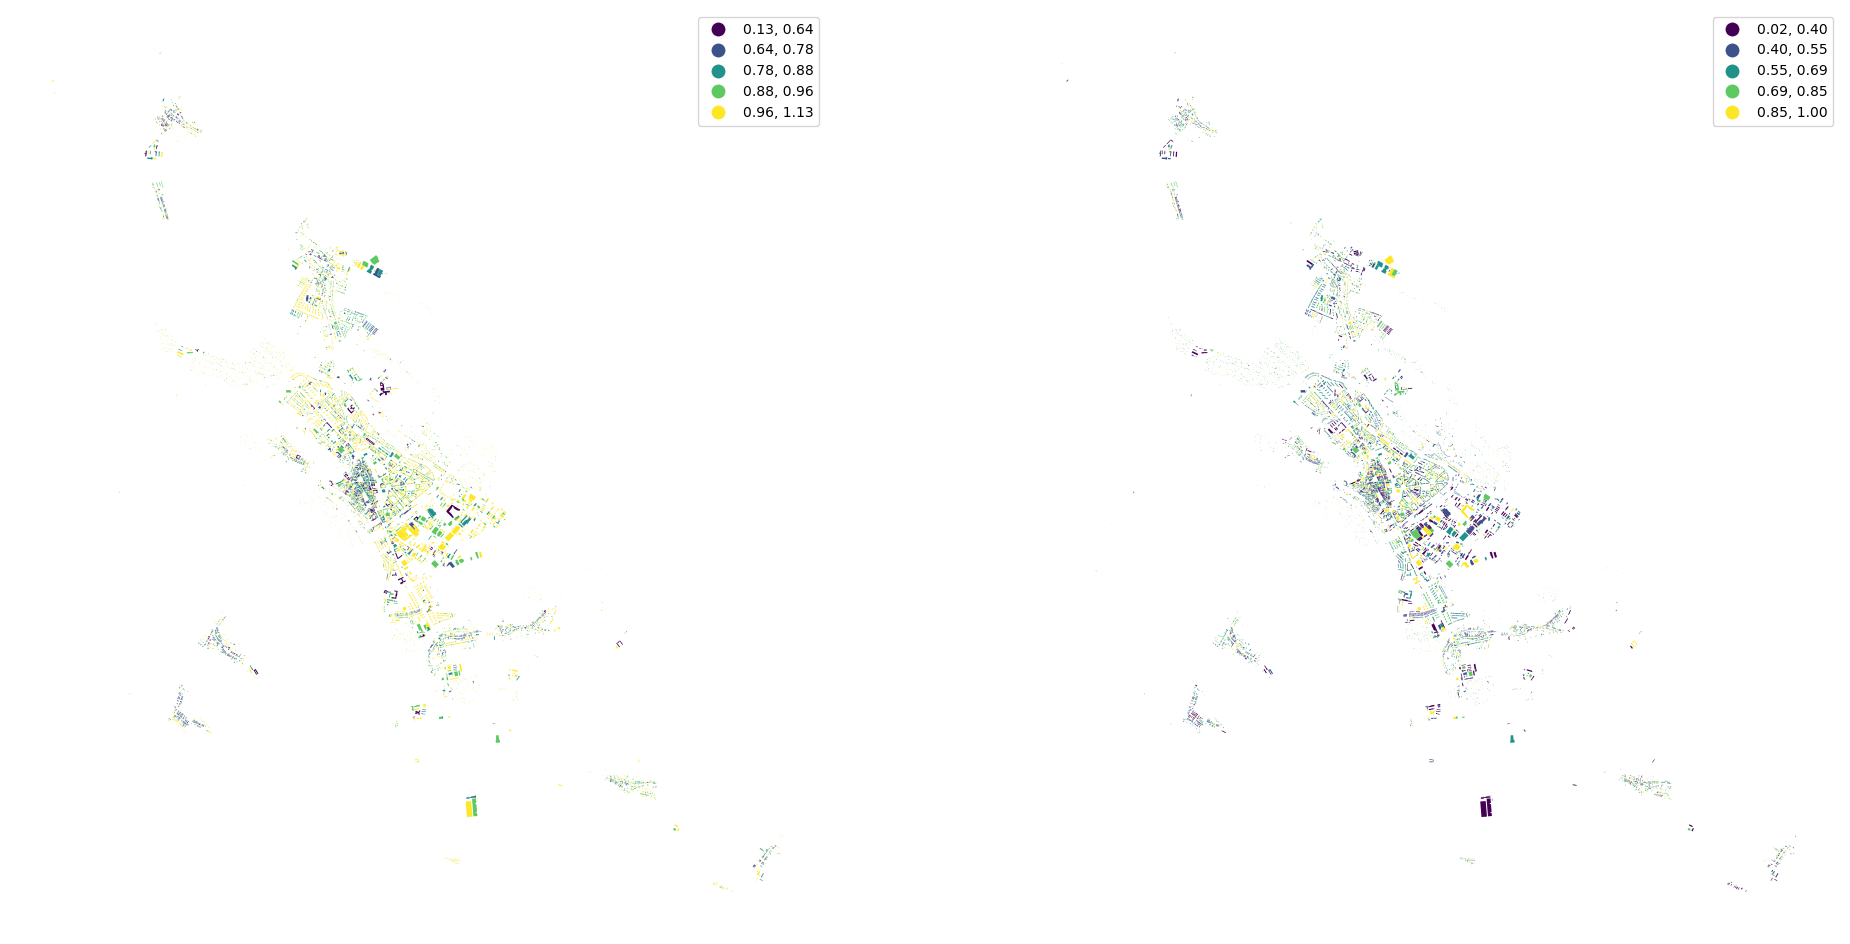

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

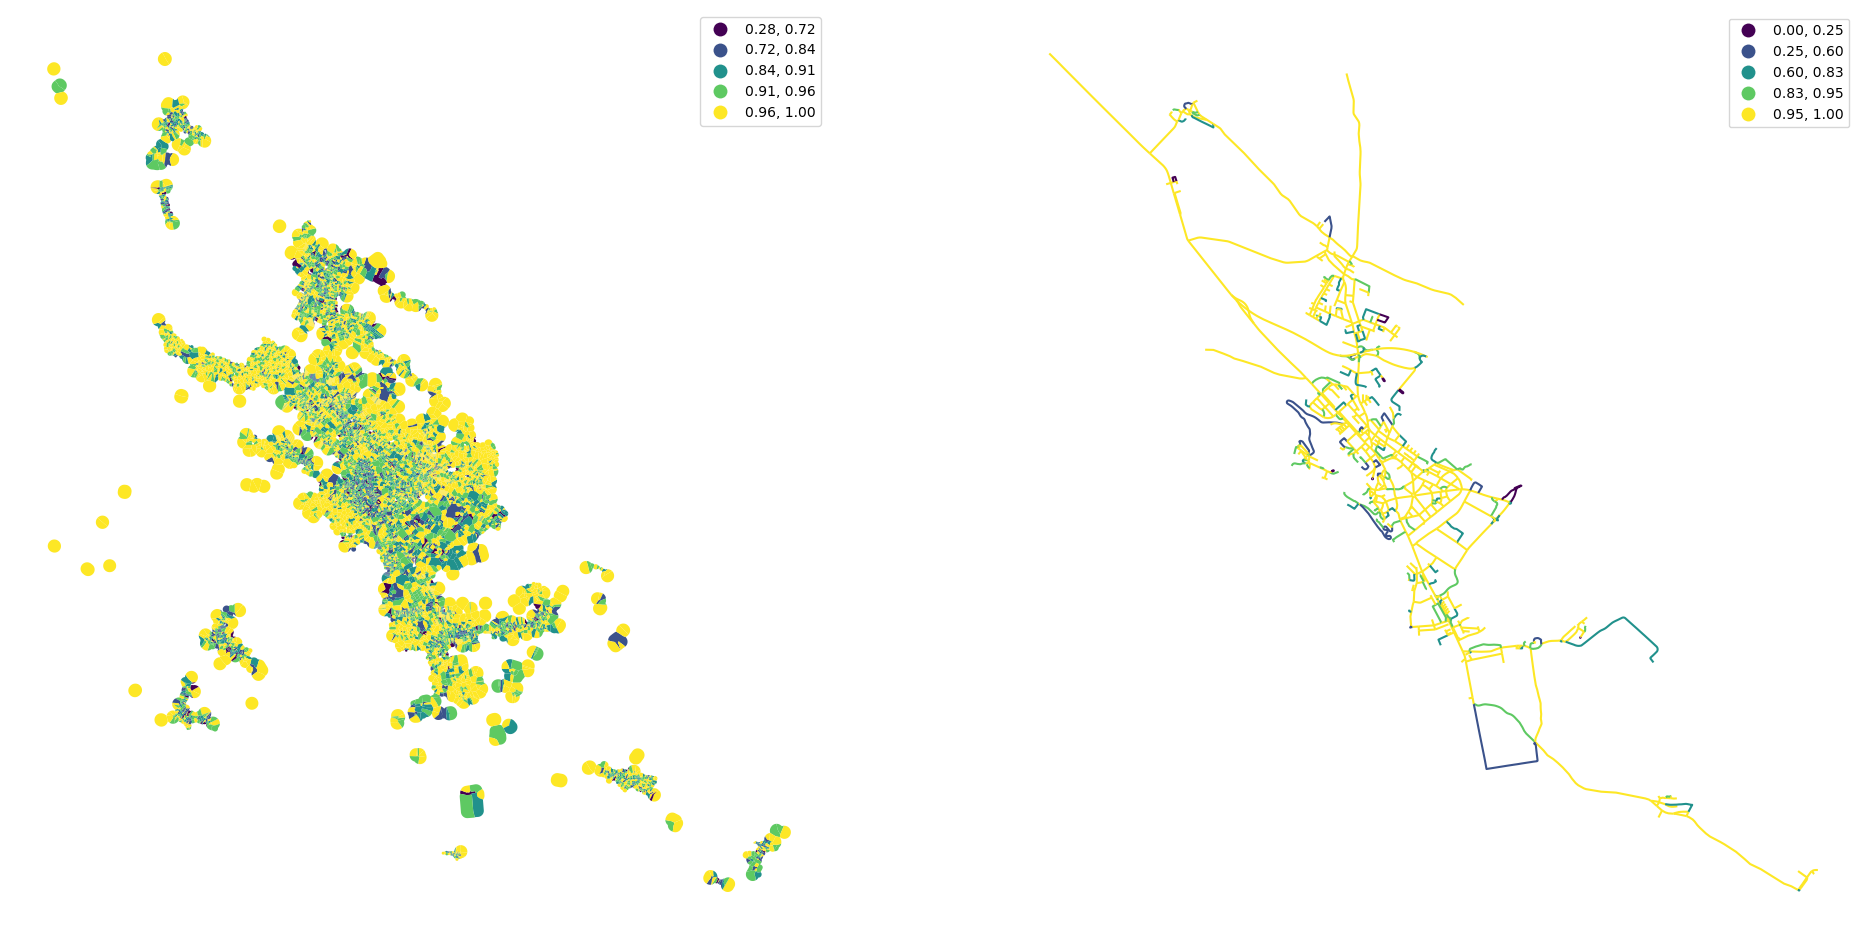

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Spatial distribution

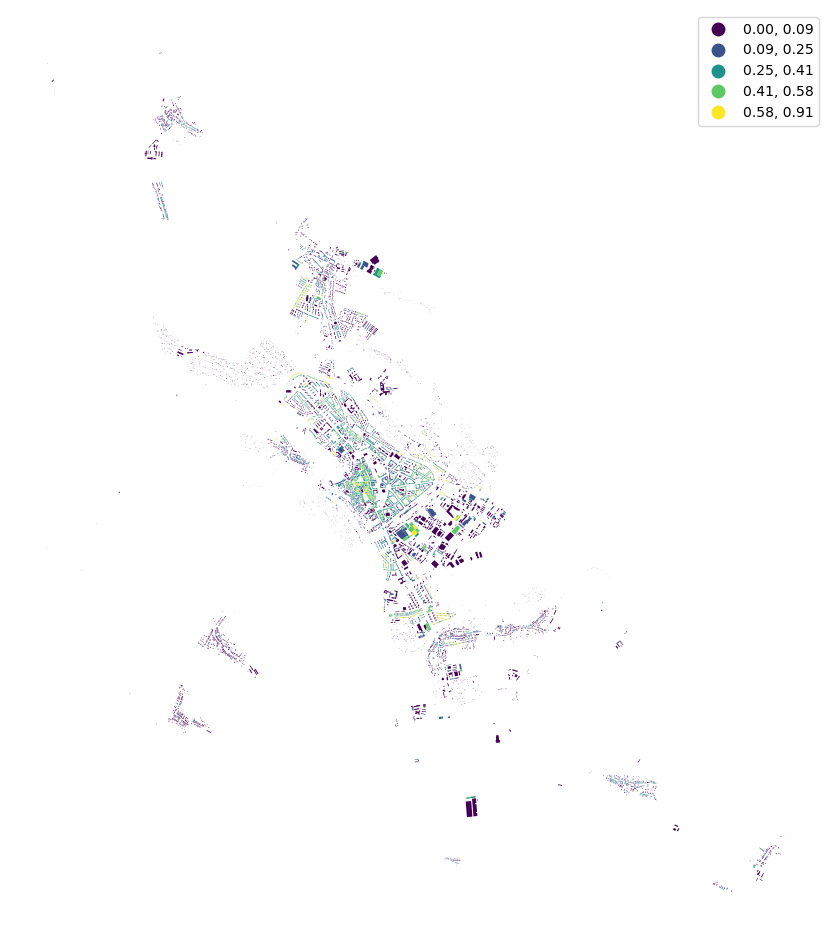

In [27]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

### Here, we will be using libpysal to generate the spatial graph.

In [28]:
queen_1 = libpysal.graph.Graph.build_contiguity(tessellation, rook=False)

In [29]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]
buildings["neighbor_distance"] = momepy.neighbor_distance(buildings, queen_1)

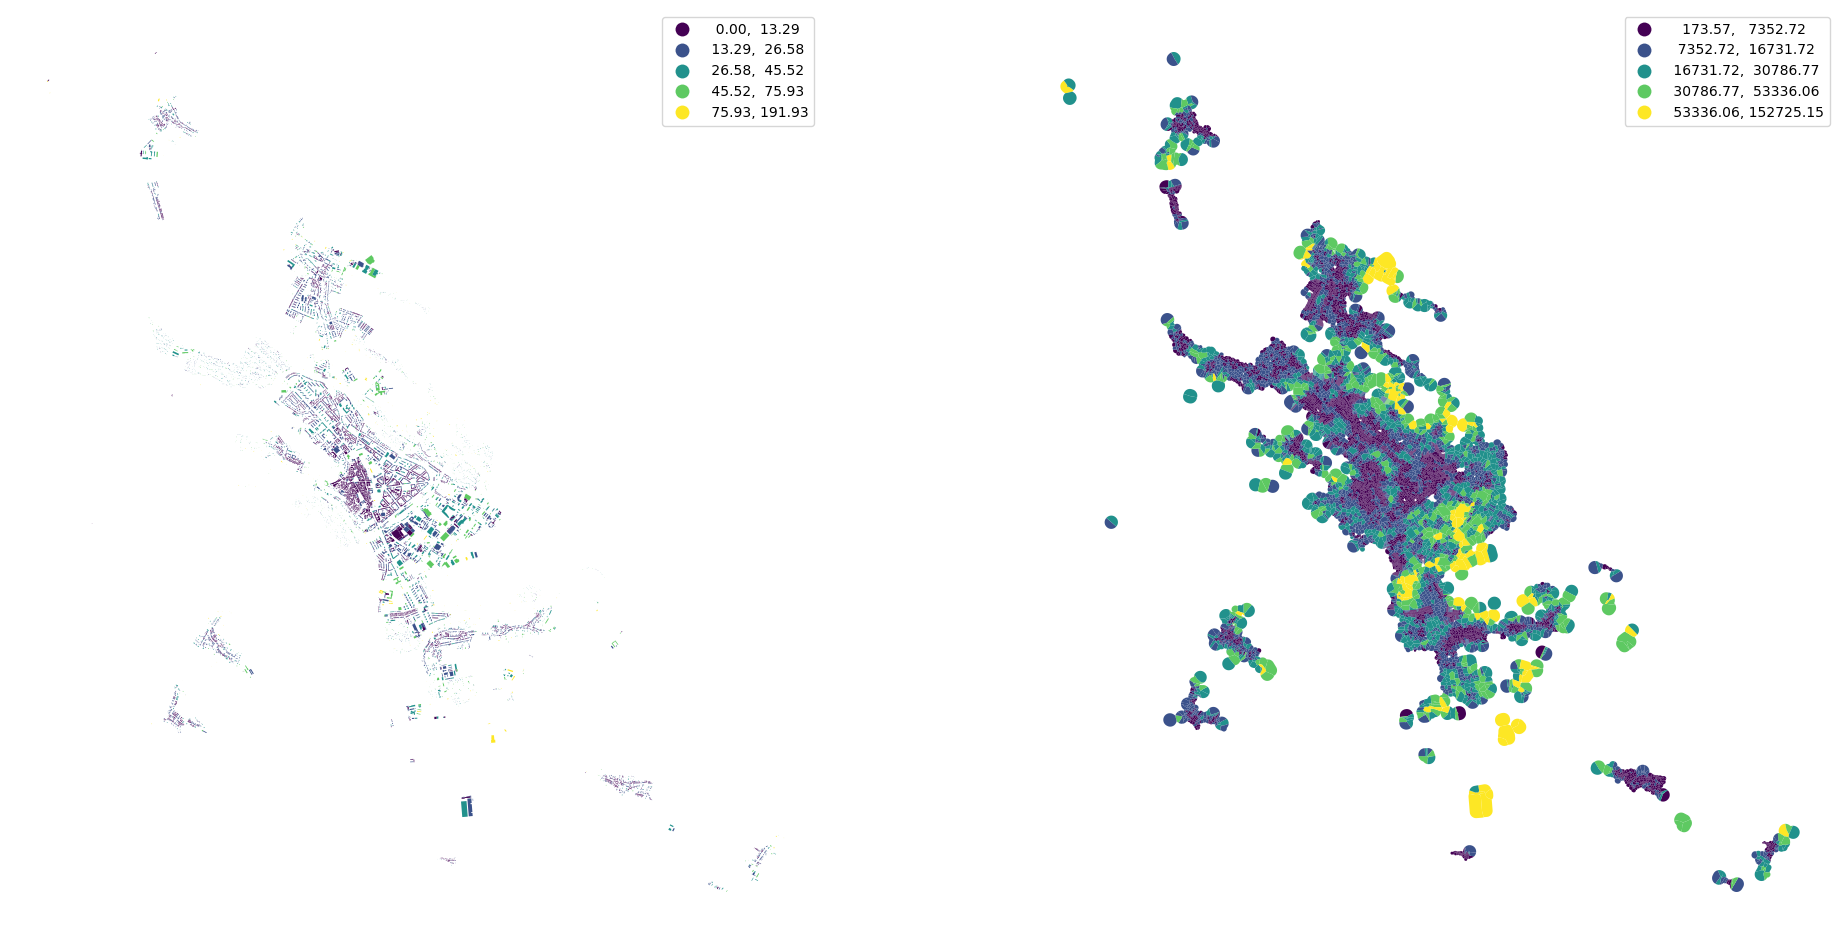

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [31]:
queen_3 = queen_1.higher_order(3)
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings, queen_1, queen_3
)
buildings["adjacency"] = momepy.building_adjacency(buildings_q1, queen_3)

C:\Users\dia\anaconda3\Lib\site-packages\momepy\functional\_distribution.py:382: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


In [32]:
!pip install scipy

In [33]:
!pip install scipy>=1.12.0


In [34]:
import scipy
print(scipy.__version__)


1.13.0


In [35]:
!pip install scipy==1.12.1


ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement scipy==1.12.1 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.9.0rc1, 1

In [36]:
!pip install scipy==1.13.0

In [37]:
import scipy 
print(scipy.__version__)

1.13.0


In [42]:
!pip install FuzzyTM>=0.4.0


In [43]:
!pip install numpy>=1.25.0


In [41]:
!pip install FuzzyTM>=0.4.0


In [44]:
!pip install scipy==1.13.0

  Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl (46.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfume 0.3.4 requires scipy==1.10.1, but you have scipy 1.13.0 which is incompatible.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.


In [45]:
import scipy 
print(scipy.__version__)

1.13.0


In [47]:
queen_3 = queen_1.higher_order(3)
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings, queen_1, queen_3
)
buildings["adjacency"] = momepy.building_adjacency(buildings_q1, queen_3)

C:\Users\dia\anaconda3\Lib\site-packages\momepy\functional\_distribution.py:382: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


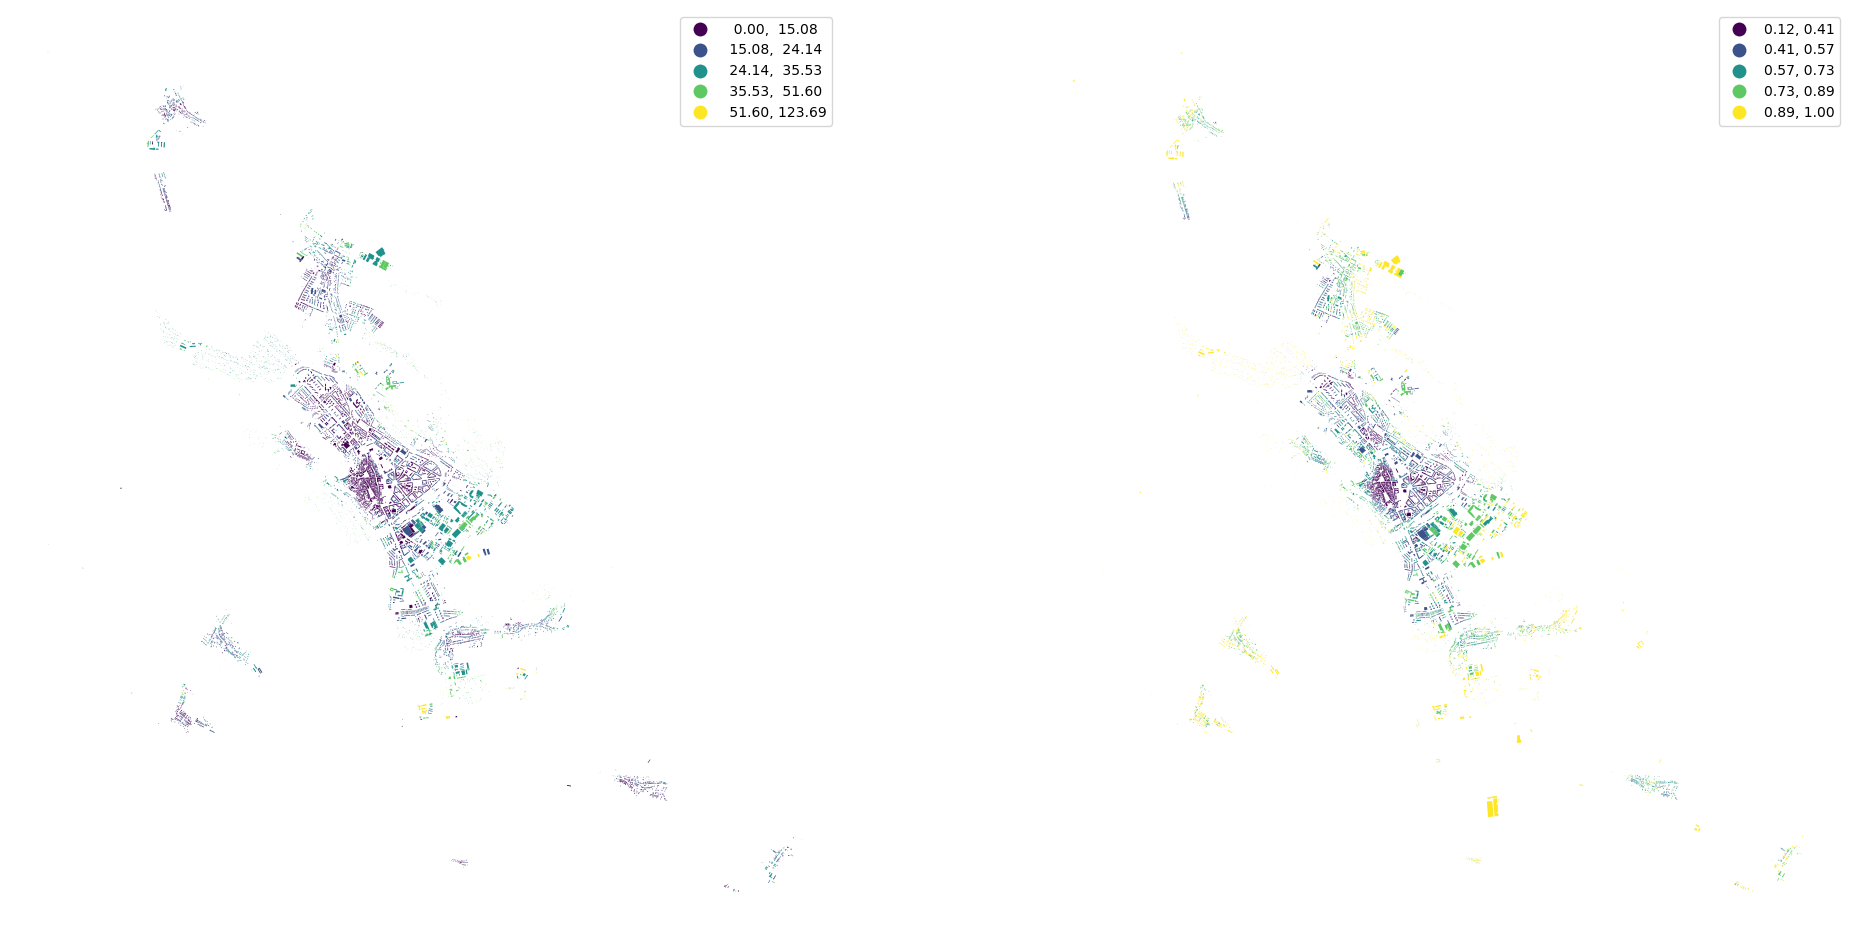

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [49]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

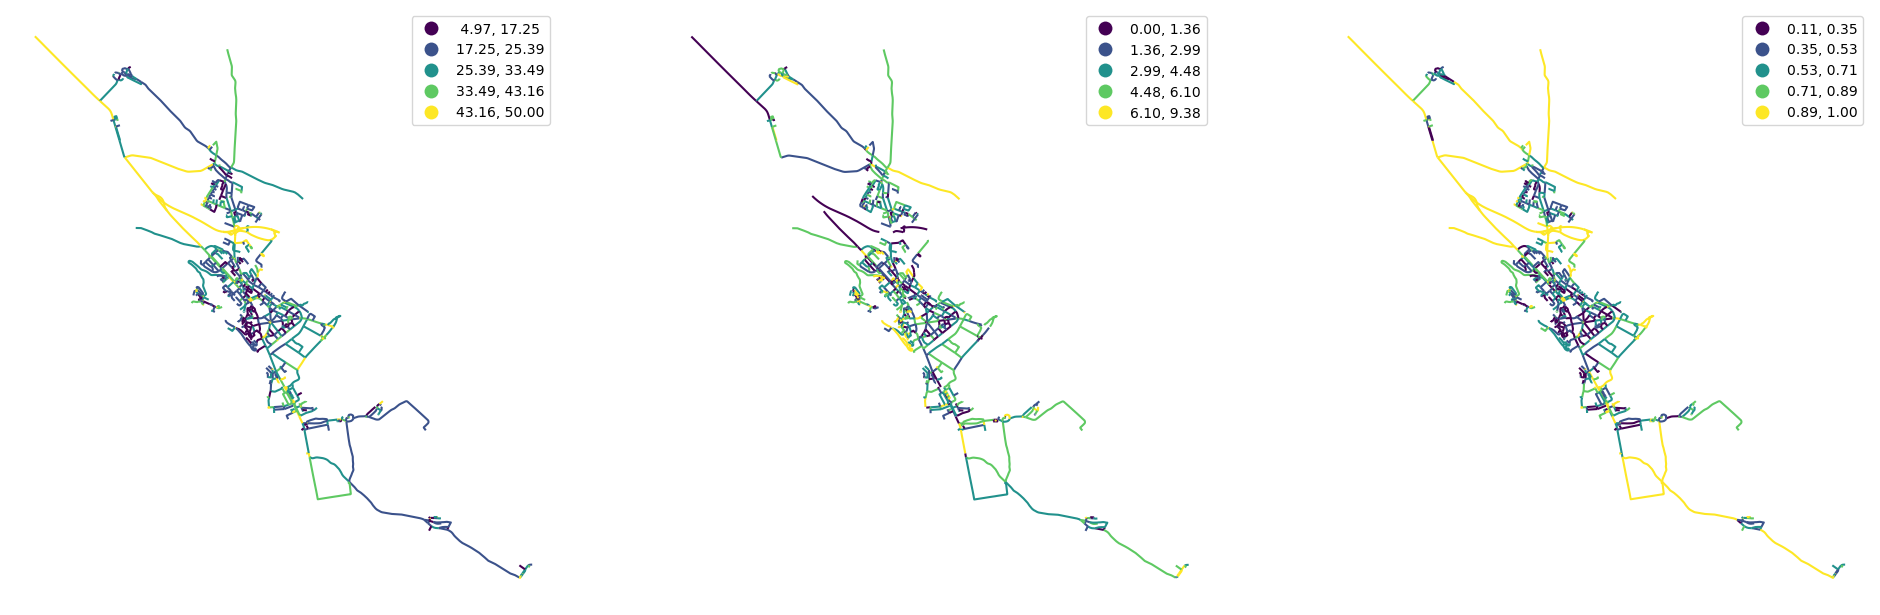

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

## Intensity

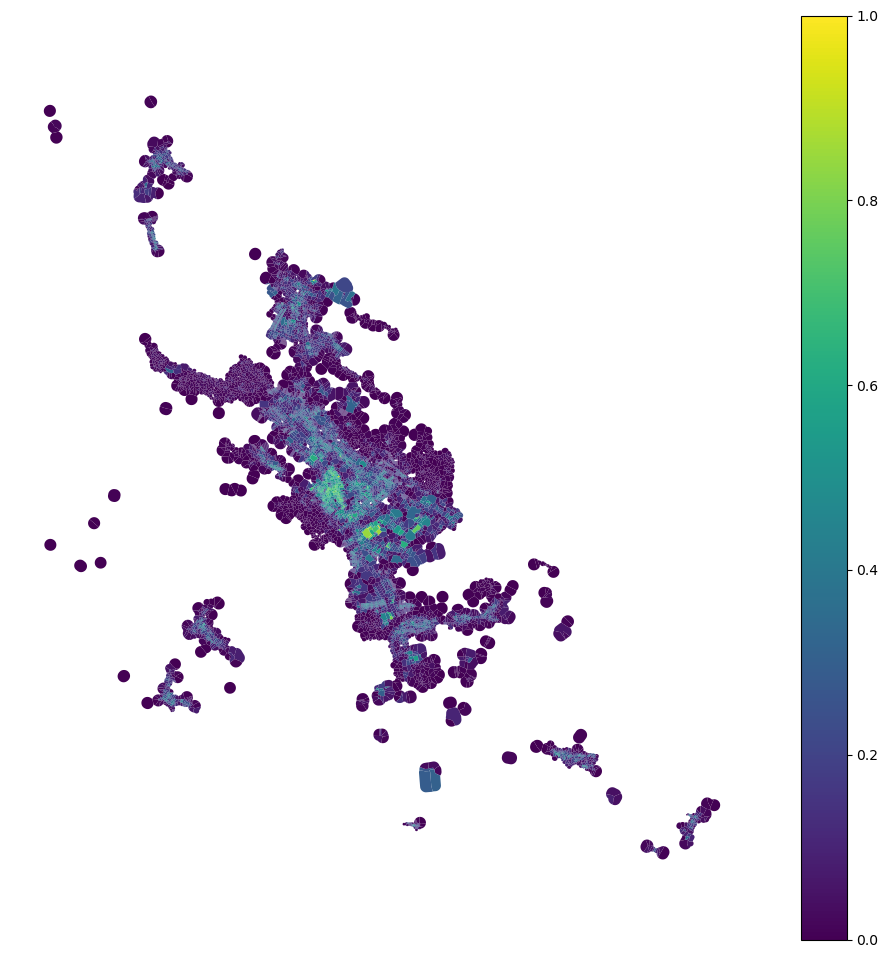

In [51]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

## Connectivity

In [52]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/780 [00:00<?, ?it/s]

C:\Users\dia\anaconda3\Lib\site-packages\mapclassify\classifiers.py:687: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self._classify()


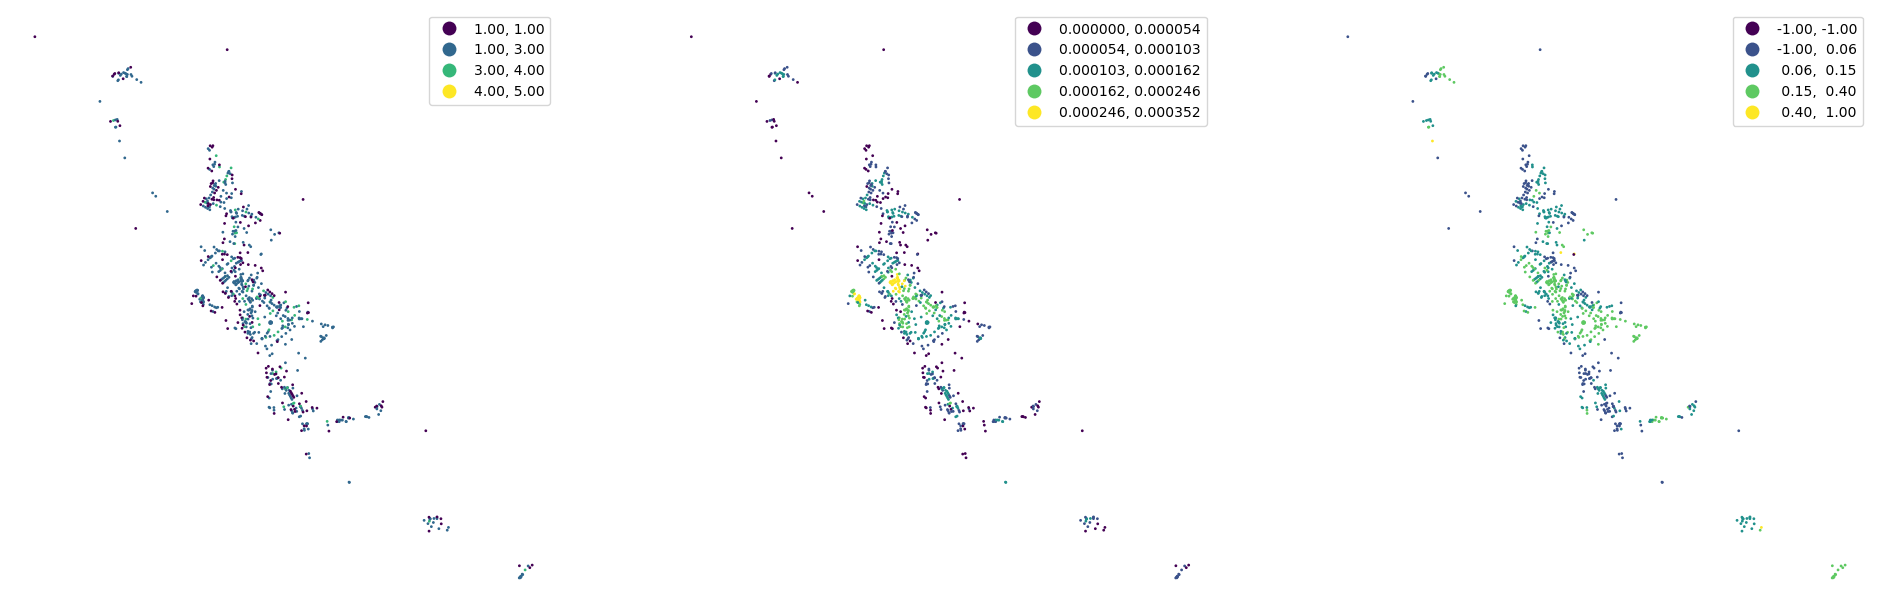

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [54]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

In [55]:
tessellation.head()

geometry  street_index  \
0  POLYGON ((-642777.212 -1194210.854, -642777.09...         347.0   
1  POLYGON ((-643063.013 -1193441.508, -643062.66...         507.0   
2  POLYGON ((-642855.499 -1193708.402, -642855.50...         371.0   
3  POLYGON ((-642950.213 -1193452.463, -642950.22...         518.0   
4  POLYGON ((-642961.162 -1193489.221, -642961.15...         518.0   

     tess_area  convexity  neighbors  covered_area       car  
0  7427.718319   0.947967   0.041016  16042.409694  0.181847  
1  1570.329339   0.943344   0.049898   4701.687233  0.490610  
2  4073.387808   0.853085   0.049119  13721.562507  0.449398  
3   676.550827   0.855153   0.066239   3190.559549  0.787121  
4  1289.581001   0.917274   0.057258   3884.232419  0.593459

In [56]:
buildings.head()

geometry  street_index  \
0  POLYGON ((-642818.791 -1194246.301, -642822.90...         347.0   
1  POLYGON ((-643052.212 -1193474.914, -643069.77...         507.0   
2  POLYGON ((-642796.708 -1193674.586, -642795.74...         371.0   
3  POLYGON ((-642960.567 -1193475.288, -642969.02...         518.0   
4  POLYGON ((-642973.521 -1193481.346, -642960.58...         518.0   

   building_area       eri  elongation  shared_walls  neighbor_distance  \
0    1350.711109  0.464112    0.436115      0.026712          43.935330   
1     770.419570  0.742491    0.971709      0.000000           7.533535   
2    1830.570622  0.544350    0.850052      0.194888          13.131563   
3     532.527489  0.646696    0.629207      0.499747           1.892698   
4     765.313279  0.630997    0.734406      0.301092           4.253296   

   interbuilding_distance  adjacency  edge_index  node_index  
0               15.613114   0.444444       536.0       306.0  
1                4.203498   0.312500       705.0       426.0  
2               10.455475   0.387755       242.0       130.0  
3                6.509125   0.285714       573.0       328.0  
4                4.153901   0.250000       573.0       433.0

In [57]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [58]:
merged.columns

Index(['geometry', 'street_index', 'tess_area', 'convexity', 'neighbors',
       'covered_area', 'car', 'building_area', 'eri', 'elongation',
       'shared_walls', 'neighbor_distance', 'interbuilding_distance',
       'adjacency', 'edge_index', 'node_index', 'length', 'linearity', 'width',
       'openness', 'width_deviation', 'mm_len', 'node_start', 'node_end', 'x',
       'y', 'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

## Understanding the context

### Measure first, second and third quartile of distribution of values within an area around each building.

In [59]:
percentiles = []
for column in merged.columns.drop(
    [
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
    ]
):
    perc = momepy.percentile(merged[column], queen_3)
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [60]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

tess_area_25  tess_area_50  tess_area_75  convexity_25  convexity_50  \
focal                                                                         
0        216.517895    579.582896   1298.482534      0.877608      0.954381   
1        230.796906    351.596940    576.142097      0.854661      0.902652   
2        251.464655    568.998502    920.470932      0.873591      0.915887   
3        149.327267    337.309025    659.810553      0.865062      0.910641   
4        211.245438    290.054420    579.825985      0.840918      0.897289   

       convexity_75  neighbors_25  neighbors_50  neighbors_75  \
focal                                                           
0          0.977556      0.040290      0.049238      0.063684   
1          0.952471      0.064120      0.071899      0.084006   
2          0.967392      0.042803      0.053485      0.079109   
3          0.961977      0.055843      0.069240      0.083822   
4          0.941941      0.053450      0.066289      0.077259   

       covered_area_25  ...          y_75  degree_25  degree_50  degree_75  \
focal                   ...                                                  
0          5119.092593  ... -1.194107e+06        3.0        3.0        3.0   
1          2005.764024  ... -1.193414e+06        3.0        3.0        3.0   
2          2739.623086  ... -1.193642e+06        3.0        3.5        4.0   
3          2604.010552  ... -1.193453e+06        3.0        3.0        3.0   
4          2056.170213  ... -1.193446e+06        3.0        3.0        3.0   

       closeness_25  closeness_50  closeness_75  meshedness_25  meshedness_50  \
focal                                                                           
0          0.000056      0.000064      0.000110       0.094156       0.095238   
1          0.000132      0.000182      0.000184       0.164179       0.184615   
2          0.000136      0.000138      0.000150       0.115942       0.133333   
3          0.000132      0.000181      0.000182       0.184615       0.215686   
4          0.000132      0.000181      0.000182       0.178082       0.215686   

       meshedness_75  
focal                 
0           0.142857  
1           0.215686  
2           0.142857  
3           0.215686  
4           0.215686  

[5 rows x 66 columns]

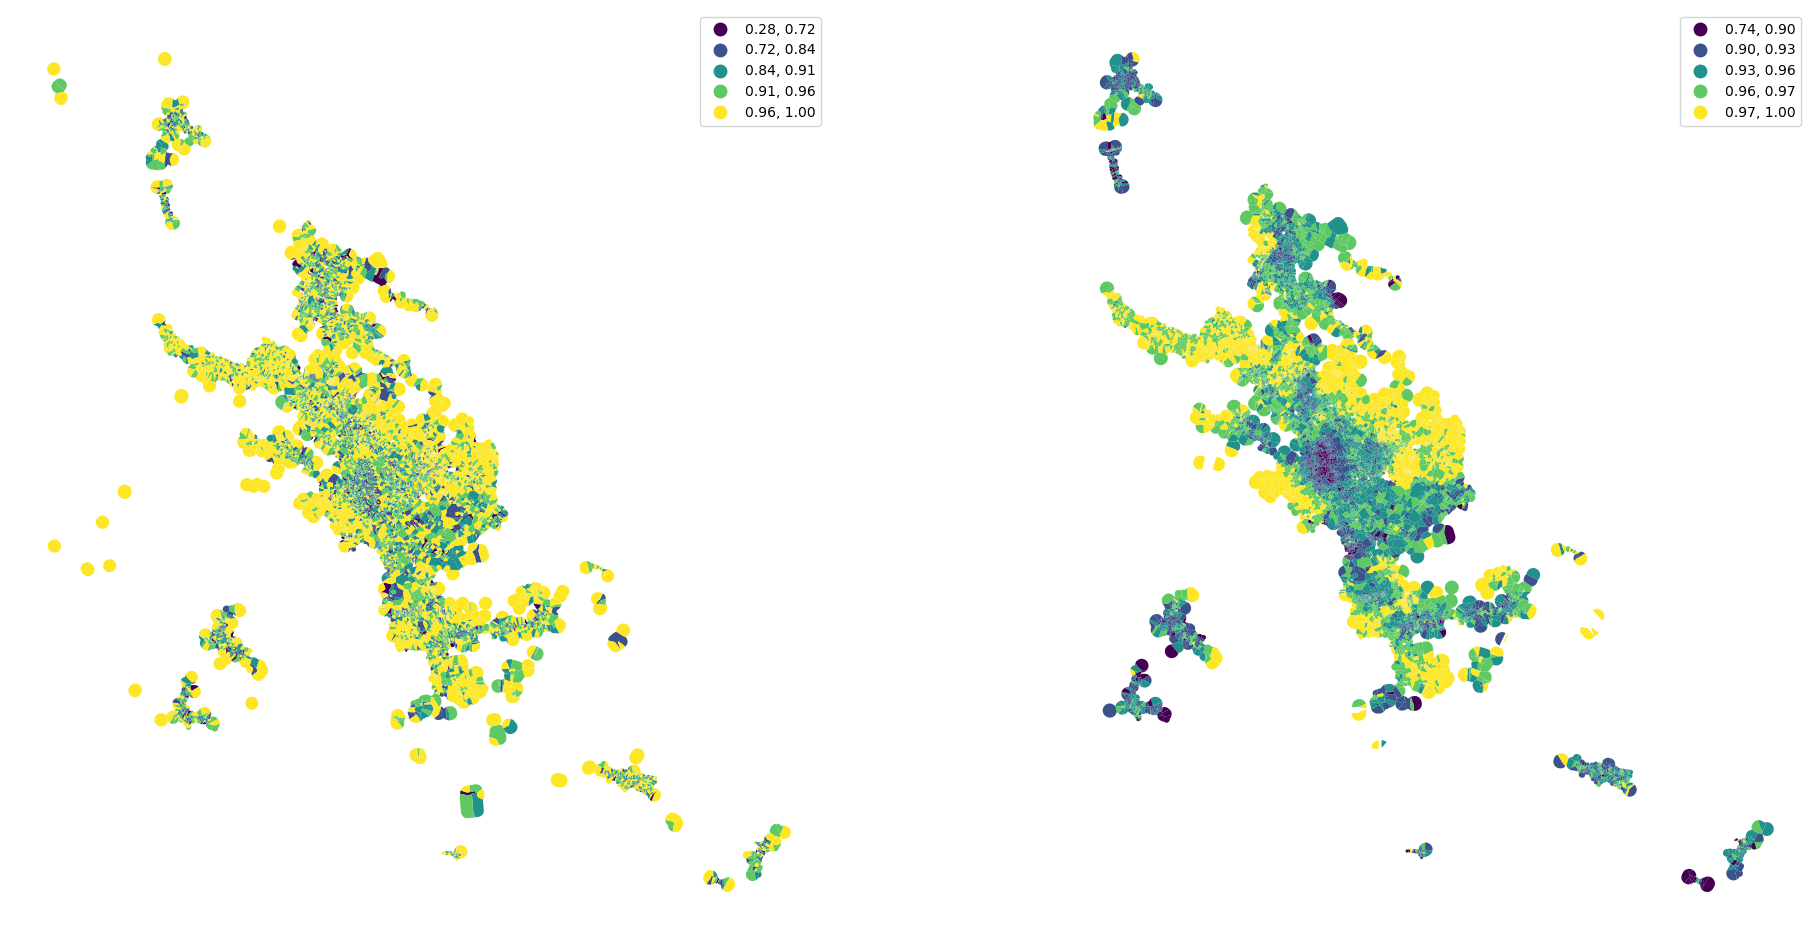

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))  #See the difference between original convexity and spatially lagged one.

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(
    percentiles_joined["convexity_50"].values,
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

### Standardizing the values before clustering.

In [62]:
standardized = (
    percentiles_joined - percentiles_joined.mean()
) / percentiles_joined.std()
standardized.head()

tess_area_25  tess_area_50  tess_area_75  convexity_25  convexity_50  \
focal                                                                         
0         -0.432189     -0.368820     -0.343144     -0.807916     -0.050637   
1         -0.413410     -0.569750     -0.703774     -1.356293     -2.054566   
2         -0.386230     -0.378148     -0.531867     -0.903916     -1.541880   
3         -0.520553     -0.582343     -0.662002     -1.107738     -1.745078   
4         -0.439123     -0.623989     -0.701935     -1.684709     -2.262309   

       convexity_75  neighbors_25  neighbors_50  neighbors_75  \
focal                                                           
0         -0.197676      0.353153      0.054642     -0.027316   
1         -1.940449      2.273651      1.428879      0.818232   
2         -0.903810      0.555634      0.312173      0.614473   
3         -1.280061      1.606549      1.267623      0.810565   
4         -2.672044      1.413719      1.088632      0.537475   

       covered_area_25  ...      y_75  degree_25  degree_50  degree_75  \
focal                   ...                                              
0            -0.057843  ... -0.337300   0.546293    0.23610  -0.086025   
1            -0.711569  ...  0.001197   0.546293    0.23610  -0.086025   
2            -0.557476  ... -0.110144   0.546293    0.90546   1.384458   
3            -0.585951  ... -0.017735   0.546293    0.23610  -0.086025   
4            -0.700985  ... -0.014100   0.546293    0.23610  -0.086025   

       closeness_25  closeness_50  closeness_75  meshedness_25  meshedness_50  \
focal                                                                           
0         -0.259234     -0.356792      0.117385       0.103968      -0.090110   
1          1.168044      1.606663      1.246223       0.850050       0.757946   
2          1.247253      0.881118      0.726138       0.336095       0.271356   
3          1.168044      1.589623      1.212163       1.067794       1.052762   
4          1.168044      1.584386      1.222073       0.998184       1.052762   

       meshedness_75  
focal                 
0           0.092544  
1           0.647474  
2           0.092544  
3           0.647474  
4           0.647474  

[5 rows x 66 columns]

### To determine how many clusters we should aim for, we can use a little package called clustergram. 

In [63]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.127 seconds.
K=3 fitted in 0.237 seconds.
K=4 fitted in 0.172 seconds.
K=5 fitted in 0.186 seconds.
K=6 fitted in 0.209 seconds.
K=7 fitted in 0.194 seconds.
K=8 fitted in 0.318 seconds.
K=9 fitted in 0.357 seconds.
K=10 fitted in 0.334 seconds.
K=11 fitted in 0.329 seconds.


In [64]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   0   2   2   2   0   2   7   2  10
1   0   0   0   1   1   5   2   3   0   3   6
2   0   0   0   1   1   5   2   3   0   3   6
3   0   0   0   1   1   5   2   3   0   3   6
4   0   0   0   1   1   5   2   3   0   3   6

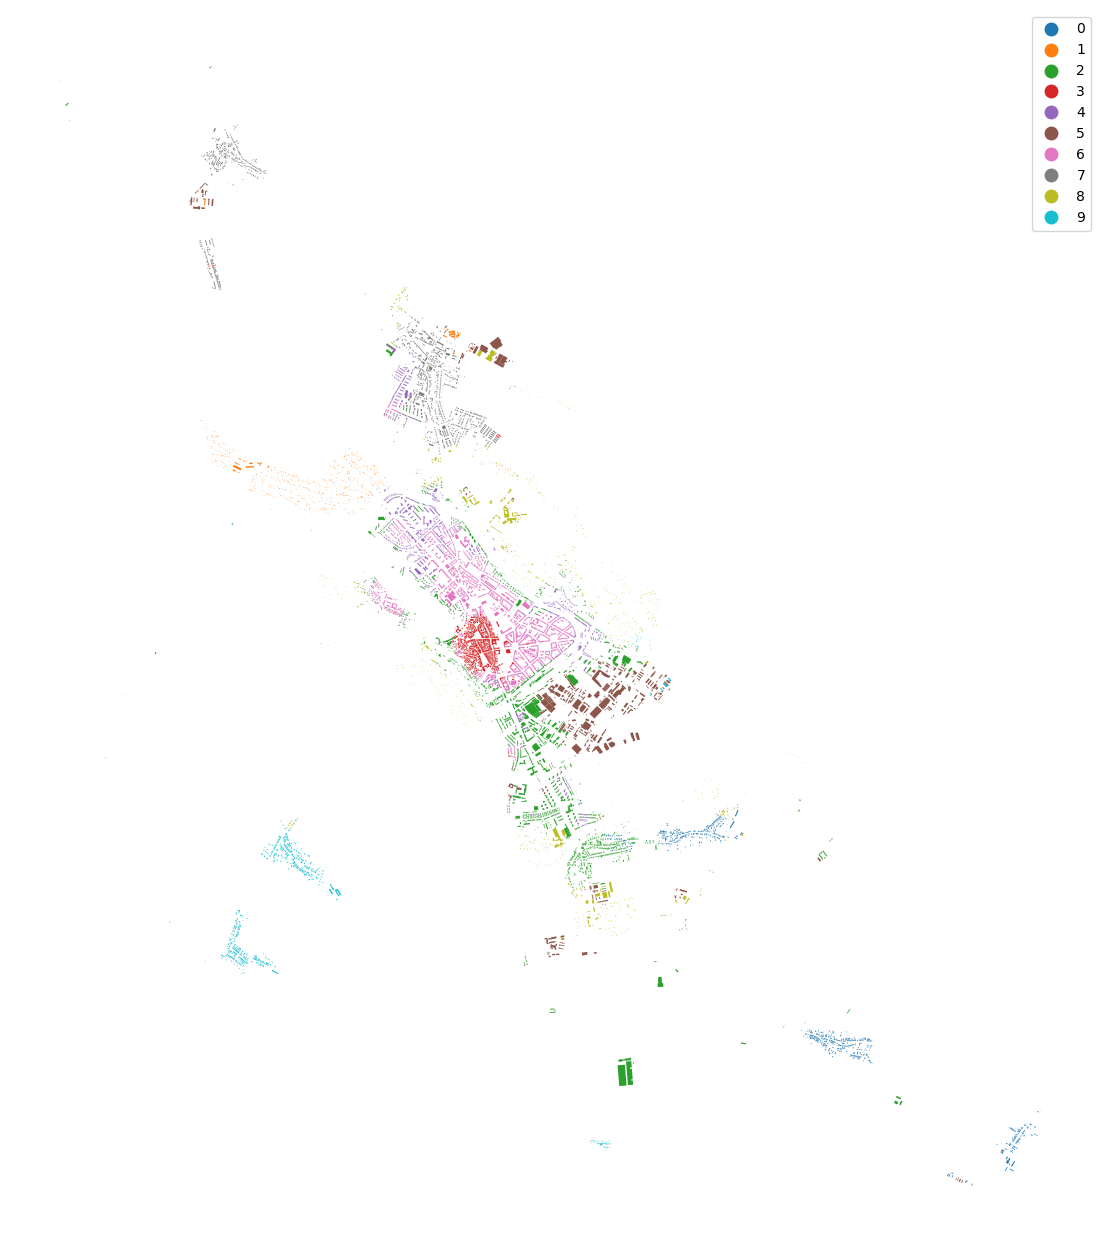

In [65]:
merged["cluster"] = cgram.labels[10].values
buildings["cluster"] = merged["cluster"]
buildings.plot(
    "cluster", categorical=True, figsize=(16, 16), legend=True
).set_axis_off()

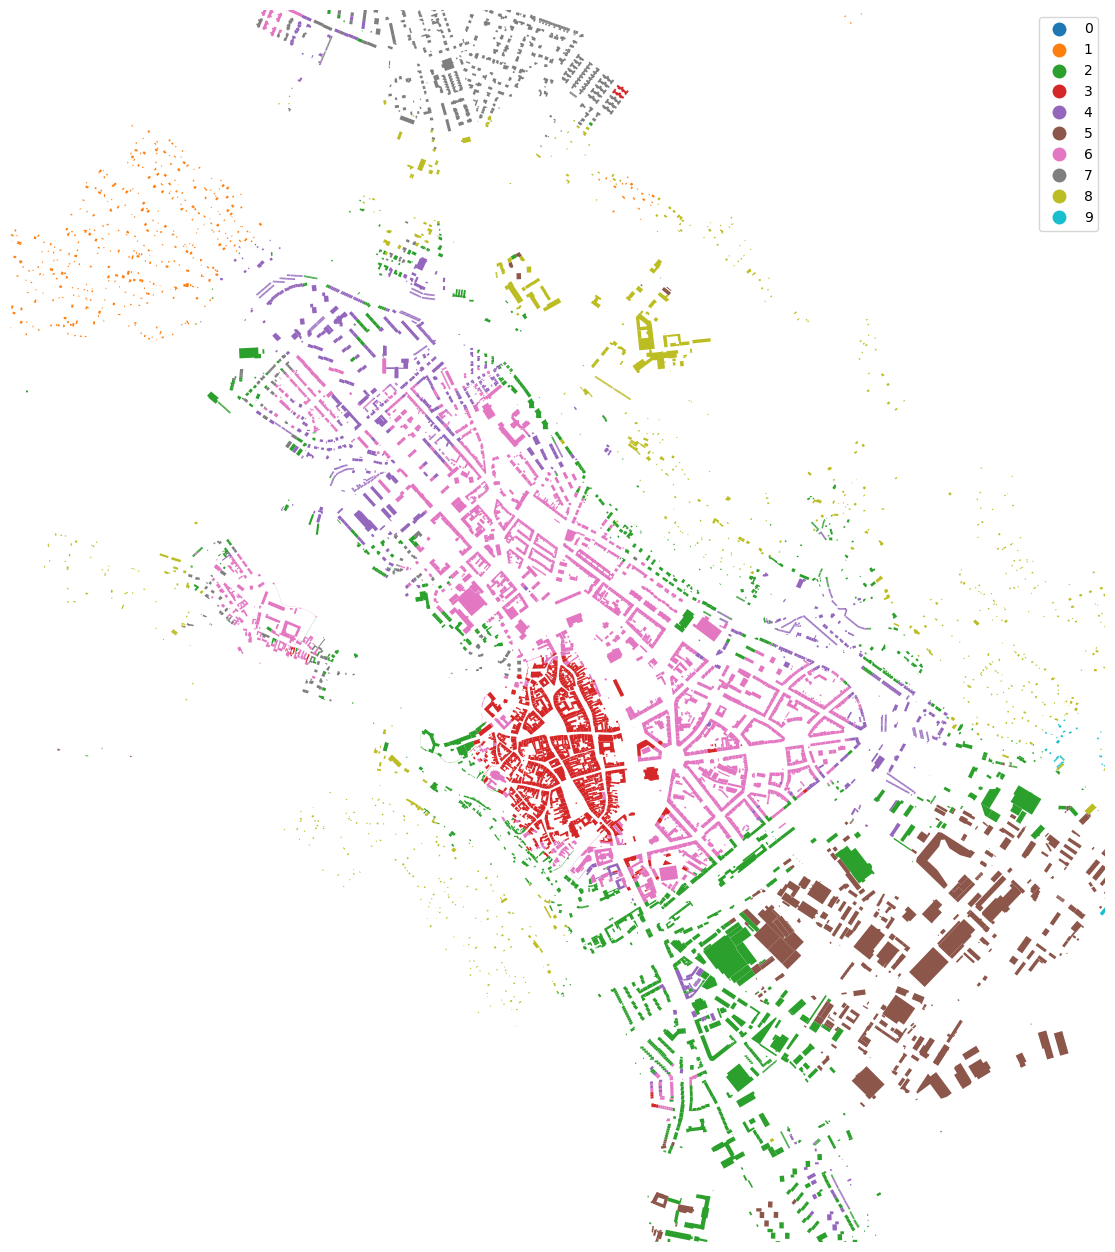

In [66]:
ax = buildings.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()